# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print(type(states[0]))
print(type(states))
#print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        #print("\nrewards = {}\n".format(rewards))
        #print(type(rewards))
        #break
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## DDPG Agent - Deep Deterministic Policy Agent

#### Imports

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque, namedtuple
import copy
import matplotlib.pyplot as plt
%matplotlib inline

#### Hyperparameters

In [7]:
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 256
UPDATE_EVERY = 3
GAMMA = 0.99
TAU = 1e-3
LR_ACTOR = 1e-4  # Learning rate of actor (try 1e-2 ???)
LR_CRITIC = 1e-4 # Learning rate of critic 1e-4 ????
RANDOM_SEED = 10

### Actor Model

In [8]:
def hidden_init(layer):
    """ Initialisation of hidden layers"""
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """
    The Actor network is an approximation of the policy function that maps states to actions
    """ 
    def __init__(self, state_size, action_size, seed=RANDOM_SEED, fc1_units=256, fc2_units=256):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)   
        
    def forward(self, state):
        if state.dim() == 1 :
            state = torch.unsqueeze(state, 0)
        x = F.leaky_relu(self.fc1(state))
        x = self.bn1(x)
        x = F.leaky_relu(self.fc2(x))
        x = F.tanh(self.fc3(x))

        return x

### Critic Model

In [9]:
class Critic(nn.Module):
    """
    The Critic network is an approximation of the action-value function 
    (Q function) that maps state-action pairs to value
    Since this is a collaborative context, the critic receives as inputs the states and actions
    for both agents
    """ 
    def __init__(self, input_size, seed=RANDOM_SEED, fc1_units=256, fc2_units=256):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1) 
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
         
    def forward(self, states, actions):
        xs = torch.cat((states, actions), dim=1)
        x = F.leaky_relu(self.fc1(xs))
        x = self.bn1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

### DDPG Agent

#### Device

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Replay Buffer
The agent learns from past experiences that are stored in a replay buffer. An experience is a named tuple $&lt;s, a, r, s^{'}, done &gt;$ . At each step (interaction of the agent with the environment) , the agent stores the response of the environment as a tuple in the replay buffer. The agent also samples at each step (once the replay buffer contains enough experiences) the replay bufferto get a batch of experiences that are used to learn the weights ($\theta, w$) of the actor and critic networks.

In [11]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed=RANDOM_SEED):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', field_names = ['states', 'actions', 'rewards', 'next_states', 'dones'])
        self.seed = random.seed(seed)
        
    def add(self, states, actions, rewards, next_states, dones):
        """push into the buffer"""
        e = self.experience(states, actions, rewards, next_states, dones)
        self.memory.append(e)

    def sample(self, batchsize, num_agents=2):
        """sample from the buffer"""
        experiences = random.sample(self.memory, self.batch_size)
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        for i in range(num_agents) :
            states.append(torch.from_numpy(np.vstack([e.states[i] for e in experiences if e is not None])).float().to(device))
            actions.append(torch.from_numpy(np.vstack([e.actions[i] for e in experiences if e is not None])).float().to(device))
            rewards.append(torch.from_numpy(np.vstack([e.rewards[i] for e in experiences if e is not None])).float().to(device))
            next_states.append(torch.from_numpy(np.vstack([e.next_states[i] for e in experiences if e is not None])).float().to(device))  
            dones.append(torch.from_numpy(np.vstack([e.dones[i] for e in experiences if e is not None]).astype(np.uint8)).float().to(device))  
            
        return (states , actions, rewards, next_states, dones)
        

    def __len__(self):
        return len(self.memory)

#### Agent

In [12]:
# https://github.com/ikostrikov/pytorch-ddpg-naf/blob/master/ddpg.py#L15
def hard_update(target, source):
    """
    Copy network parameters from source to target
    Inputs:
        target (torch.nn.Module): Net to copy parameters to
        source (torch.nn.Module): Net whose parameters to copy
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)
        
num_agents = 2
states_size = num_agents * state_size
actions_size = num_agents * action_size

critic = Critic(states_size + actions_size).to(device)
target_critic = Critic(states_size + actions_size).to(device)
hard_update(target_critic, critic)

class Agent:
    """
    Deep Deterministic Policy Gradient agent equipped with actor & critic networks (local and target)
     --> The actor network is used to predict the action based on the input observations
     --> The critic nework is the qvalue function.
    Only the parameters of the local networks are optimized.
    The parameters of the target networks follow those of the local networks (soft updates)
    
    critic input = obs_full + actions = (24 * 2) + 2 + 2 = 52
    """
     
    def __init__(self):
        super(Agent, self).__init__()
        self.actor = Actor(state_size, action_size).to(device)
        self.critic = critic
        self.target_actor = Actor(state_size, action_size).to(device)
        self.target_critic = target_critic 
        
        # self.noise = OUNoise(action_size, scale=1.0)
        
        # initialize target
        hard_update(self.target_actor, self.actor)
 
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)
        
    def act(self, state):
        state = torch.from_numpy(state).float().to(device)
        self.actor.eval()
        with torch.no_grad() :
            action = self.actor(state).cpu().data.numpy() # + noise * self.noise.noise()
        self.actor.train()
        return action
        #return np.clip(action, -1, 1)

### Multi Agent DDPG

In [13]:
# https://github.com/ikostrikov/pytorch-ddpg-naf/blob/master/ddpg.py#L11
def soft_update(target, source, tau=TAU):
    """
    Perform DDPG soft update (move target params toward source based on weight
    factor tau)
    Inputs:
        target (torch.nn.Module): Net to copy parameters to
        source (torch.nn.Module): Net whose parameters to copy
        tau (float, 0 < x < 1): Weight factor for update
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)


class MADDPG:
    def __init__(self, num_agents=2):
        super(MADDPG, self).__init__() 
        self.num_agents = num_agents
        self.maddpg_agent = [Agent() for i in range(num_agents)] # 2 agents        
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        self.t_step = 0
    
    def act(self, obs_all_agents):
        """get actions from all agents in the MADDPG object"""
        actions = [agent.act(obs) for agent, obs in zip(self.maddpg_agent, obs_all_agents)]
        return actions

    
    def step(self, states, actions, rewards, next_states, dones):
        self.memory.add(states, actions, rewards, next_states, dones)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0 :
            if len(self.memory) > BATCH_SIZE :
                experiences = self.memory.sample(BATCH_SIZE)
                # First agent
                self.learn(experiences, 0, GAMMA)
                # Second Agent
                self.learn(experiences, 1, GAMMA) 

                
    def learn(self, experiences, i_agent, gamma):
        (states, actions, rewards, next_states, dones) = experiences
        agent = self.maddpg_agent[i_agent]
        
        ############ update critic network ###############
        agent.critic_optimizer.zero_grad()

        next_actions = []
        for i, a in enumerate(self.maddpg_agent):
            next_actions.append(a.target_actor(next_states[i]))
        target_actions = torch.cat(next_actions, dim=1)
        target_states = torch.cat(next_states, dim=1)
        #target_critic_input = torch.cat([torch.cat(next_states, dim=1), target_actions], dim=1)

        #with torch.no_grad() :
        q_next = agent.target_critic(target_states, target_actions)
        y = rewards[i_agent].view(-1,1) + GAMMA * (1 - dones[i_agent].view(-1,1))
        
        current_states = torch.cat(states, dim=1)
        current_actions = torch.cat(actions, dim=1)
        #critic_input = torch.cat([torch.cat(states, dim=1), current_actions], dim=1)
        q = agent.critic(current_states, current_actions)
        
        #huber_loss = torch.nn.SmoothL1Loss()
        #critic_loss = huber_loss(q, y.detach())
        critic_loss = F.mse_loss(q, y.detach())
        critic_loss.backward()
        agent.critic_optimizer.step()
        
        ############ update actor network ###############
        agent.actor_optimizer.zero_grad()
            
        actions_pred = [self.maddpg_agent[i].actor(state) if i == i_agent \
                   else self.maddpg_agent[i].actor(state).detach() \
                   for i, state in enumerate(states) ]
        actions_pred = torch.cat(actions_pred, 1)
        #q_input = torch.cat([torch.cat(states, dim=1), torch.cat(actions_pred, dim=1)], dim=1)
        actor_loss = -agent.critic(current_states, actions_pred).mean() # no mean() here ????
        actor_loss.backward()
        # nn.utils.clip_grad_norm_(agent.critic.parameters(), 1.)
        agent.actor_optimizer.step()
        
        ############## . Update target networks ##############
        self.update_targets()
            
    def update_targets(self):
        """soft update targets"""
        for ddpg_agent in self.maddpg_agent:
            soft_update(ddpg_agent.target_actor, ddpg_agent.actor)
            soft_update(ddpg_agent.target_critic, ddpg_agent.critic)
        
        
        
        
        
        

#### Noise

In [14]:
# from https://github.com/songrotek/DDPG/blob/master/ou_noise.py
class OUNoise:

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2): 
        random.seed(seed)
        np.random.seed(seed)
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.size)
        self.state = x + dx
        return self.state 


### Main Training Loop

Episode 50 	 Average Score : 0.00040
Episode 100 	 Average Score : 0.00046
Episode 150 	 Average Score : 0.00048
Episode 200 	 Average Score : 0.00070
Episode 250 	 Average Score : 0.00073
Episode 300 	 Average Score : 0.00057
Episode 350 	 Average Score : 0.00104
Episode 400 	 Average Score : 0.00125
Episode 450 	 Average Score : 0.00091
Episode 500 	 Average Score : 0.00071
Episode 550 	 Average Score : 0.00050
Episode 600 	 Average Score : 0.00032
Episode 650 	 Average Score : 0.00034
Episode 700 	 Average Score : 0.00064
Episode 750 	 Average Score : 0.00086
Episode 800 	 Average Score : 0.00060
Episode 850 	 Average Score : 0.00018
Episode 900 	 Average Score : 0.00002
Episode 950 	 Average Score : 0.00023
Episode 1000 	 Average Score : 0.00030

 Average length of episodes = 17.7


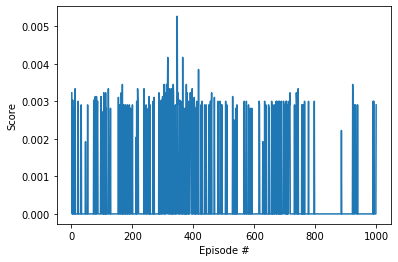

In [15]:
num_episodes = 1000
num_agents = 2

# amplitude of OU Noise
# this slowly decrease to zero

noise = OUNoise(action_size, RANDOM_SEED)
noise_reduction = 1.0 #0.99999
t_stop_noise = 12000

# initialize policy and critic
maddpg = MADDPG(num_agents)

# scores 
scores = []
scores_deque = deque(maxlen=100)

# step index (across all episodes !!!)
i_step = 0 

print_every = 50

for i_episode in range(1, num_episodes + 1) :
    
    agent0_rewards = []
    agent1_rewards = []
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                 # get the current state (for each agent)
    
    while True : 
        i_step += 1
        noise_reduction *= noise_reduction
        actions = maddpg.act(states)
        if (i_step < t_stop_noise) :
            noises = [noise.noise() * noise_reduction for i in range(num_agents)] 
            actions = [np.clip(np.add(a,n), -1, 1)  for (a,n) in zip(actions, noises)]

        #if i_step % 200 == 0 :
        #    print("\nActions without noise= {}".format(actions))
        #    print("\nNoisy actions = {}\n".format(actions1))

        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished

        
        maddpg.step(states, actions, rewards, next_states, dones)
        states = next_states
        agent0_rewards.append(rewards[0])
        agent1_rewards.append(rewards[1])
        
        if np.any(dones):
            break
    
    score = max(np.mean(agent0_rewards), np.mean(agent1_rewards))
    scores.append(score)
    scores_deque.append(score)
    print('\rEpisode {} \t Average Score : {:.5f}'.format(i_episode, np.mean(scores_deque)), end="")
    if  i_episode % print_every == 0 :
        print('\rEpisode {} \t Average Score : {:.5f}'.format(i_episode, np.mean(scores_deque)))

print("\n Average length of episodes = {:.1f}".format(i_step * 1.0 / num_episodes))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('scores.jpg')
plt.show()




When finished, you can close the environment.

In [ ]:
env.close()

## Scratch

In [ ]:
import numpy as np

In [ ]:
print(actions)
noise = OUNoise(action_size, scale=0.5)
#noises = [ noise.noise() for _ in range(num_agents)]

noises = [noise.noise() * np.power(noise_reduction, 1) for i in range(num_agents)] 
print(noises)
[np.clip(np.add(a,n), -1, 1) for (a,n) in zip(actions, noises)]


#oise = ounoise.noise()
#print(noise)
#print(actions + noise)
#np.clip(actions + noise, -1, 1)

In [ ]:
np.power(0.9997,13000)

In [ ]:
class Network(nn.Module):
    """ 
    Baseline network for actor and critic in DDPG agent:
    4 fully connected layers
    """
    def __init__(self, input_dim, hidden_in_dim, hidden_mid_dim, hidden_out_dim, output_dim, actor=True):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_in_dim)
        self.fc2 = nn.Linear(hidden_in_dim, hidden_mid_dim)
        self.fc3 = nn.Linear(hidden_mid_dim, hidden_out_dim)
        self.fc4 = nn.Linear(hidden_out_dim, output_dim)
        self.nonlin = F.relu # leaky_relu
        self.actor = actor
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-1e-3, 1e-3)
        
    def forward(self, x):
        if self.actor :
            # return a vector of the force ??????
            h1 = self.nonlin(self.fc1(x))
            h2 = self.nonlin(self.fc2(h1))
            h3 = self.nonlin(self.fc3(h2))
            return F.tanh(self.fc4(h3))
            
        else:
            # critic network simply outputs a number
            h1 = self.nonlin(self.fc1(x))
            h2 = self.nonlin(self.fc2(h1))
            h3 = self.nonlin(self.fc3(h1))
            return self.fc4(h3)
        